# Code for Enumeration of max-pooling responses with generalized permutahedra

## version of September 25, 2022

This Jupyter notebook contains code in Sage related to the paper "Enumeration of max-pooling responses with generalized permutahedra" by Laura Escobar, Patricio Gallardo, Javier González Anaya, José L. González, Guido Montúfar, and Alejandro H. Morales.



The main polytopes we study: $P_{n,ks}$ and $Q_n$

In [42]:
# Code for sums of simplices
# coordinate simplex I is a set of {0,1,...,n-1}
def Delta(I,n):
    IM = identity_matrix(n)
    return Polyhedron(vertices=[IM[e] for e in I],backend='normaliz')

# this generates a Minkowski sum of coordinate simplices. This is a special kind of generalized permutahedra
# SL is a list of sets of [n], yL is a list of positive integers of the same size
# returns Minkowski sum of yL[i]*Delta(SL[i])
def Py(n,SL,yL):
    return sum(yL[i]*Delta(SL[i],n) for i in range(len(SL)))

# Code that returns the polytopes P_n,k,s of one dimensional arrays that are the Minkowski sum of n simplices Delta[s*i,s*i+1,...,s*i+k-1] for i=0,..,n-1.
def PP(n,k,s):
    SS = [set(range(s*i,k+s*i)) for i in range(n)],[1,]*(n)
    print(SS)
    return Py(s*(n-1)+k,SS[0],SS[1])

# Code that returns the polytope Q_n from two dimensional arrays that are Minkoski sums of 3D simplices with vertices in 2x2 window on a 3xn input.
def Q(n):
    SS = [set([3*k,3*k+1,3*k+3,3*k+4]) for k in range(n-1)] + [set([3*k+1,3*k+2,3*k+4,3*k+5]) for k in range(n-1)]
    print(SS)
    return Py(3*n,SS,[1,]*2*(n-1))
    

Example: $P_{2,3,1} = \Delta_{0,1,2} + \Delta_{1,2,3}$

In [2]:
P = PP(2,3,1)
P

([{0, 1, 2}, {1, 2, 3}], [1, 1])


A 3-dimensional polyhedron in ZZ^4 defined as the convex hull of 7 vertices (use the .plot() method to plot)

In [3]:
P.f_vector()

(1, 7, 11, 6, 1)

In [4]:
QP = Q(2)
QP.f_vector()

[{0, 1, 3, 4}, {1, 2, 4, 5}]


(1, 14, 37, 43, 26, 8, 1)

In [5]:
QP = Q(3)
QP.f_vector()

[{0, 1, 3, 4}, {3, 4, 6, 7}, {1, 2, 4, 5}, {8, 4, 5, 7}]


(1, 150, 692, 1432, 1705, 1256, 574, 154, 21, 1)

##  Section 3: model for faces of generalized permutahedra

In [51]:
# Code 
from itertools import *
from collections import defaultdict

# lamsets are the sets of the vertices of the coordinate simplices with groundset {0,1,...,r-1} for some r
def get_face_partitions(lamsets):
    R = len(lamsets)
    P = product(*[list(range(1,2^len(lam))) for lam in lamsets])
    VPS = []
    for p in P:
        currVP = []
        for i in range(R):
            lam = lamsets[i]
            W = Set(lam).subsets()[p[i]]
            L = Set(lam).symmetric_difference(W)
            currVP.append((W,L))
        VPS.append(currVP)
    return VPS

# r is the size of the groundset {0,1,...,r-1}, 
# Pi is the face partitions written as [(F1,complement(F1)),...,(Fk,complement(Fk))], 
# R are the equivalence classes on {0,1,...,r-1} induced by Pi
def Partition_to_Graph(r,Pi,R):
    R = get_equivalence_classes(r,Pi)
    A = []
    for pair in combinations(range(len(R)),r=2):
        a,b = R[pair[0]],R[pair[1]]
        if is_edge(a,b,Pi):
            A.append(pair)
        if is_edge(b,a,Pi):
            A.append((pair[1],pair[0]))
    for i in range(len(R)):
        a = R[i]
        if is_edge(a,a,Pi):
            A.append((i,i))
    return DiGraph([list(range(len(R))),A],loops=True)

# r is the size of the ground set {0,1,2,...,r-1} and Pi is the face partitions written as [(F1,complement(F1)),...,(Fk,complement(Fk))]
def get_equivalence_classes(r,Pi):
    R = []
    for pt in Pi:
        W = pt[0]
        for pairs in combinations(W,2):
            R.append(pairs)
            R.append(pairs[::-1])
    D = DiGraph([list(range(r)),R])
    #D = DiGraph([list(range(1,r+1)),R])
    return D.connected_components()

def is_edge(a,b,Pi):
    return any([not(Set(a).intersection(Set(pt[0])).is_empty()) and not(Set(b).intersection(Set(pt[1])).is_empty()) for pt in Pi])



class Graph_Partition(Parent):
    def __init__(self, r, Pi):
        self.size = r
        self.ptn = Pi
        self.equiv_classes = get_equivalence_classes(r,Pi)
        self.G = Partition_to_Graph(r, Pi, self.equiv_classes)
        
    def get_Partition(self):
        return self.ptn
    
    def get_vertices(self):
        return self.equiv_classes
    
    def get_graph(self):
        return self.G

    def is_acyclic(self):
        return self.G.is_directed_acyclic()

    def get_dim(self):
        return self.size - len(self.G.vertices())



### Example 3.5

Consider the simplices $\Delta_{\lambda_{i}}\subseteq\R^{5}$, where $\lambda_i:=\{i,i+1,i+2\}$ for $i\in[3]$. Then, the two lists of faces
  $\Pi=\left(\Delta_{\{01\}},\Delta_{\{123\}},\Delta_{\{23\}}\right)$ and $\Pi'=\left(\Delta_{\{012\}},\Delta_{\{123\}},\Delta_{\{23\}}\right)$.
  
  We encode such partitions $\Pi$ as a list of tuples $[(F_i,\lambda_i\setminus F_i) \mid F_i \in \Pi]$

In [52]:
Pi = [({0,1},{2}),({1,2,3},{}),({2,3},{4})]

In [53]:
GPi = Graph_Partition(5,Pi)

In [54]:
GPi.get_vertices()

[[0, 1, 2, 3], [4]]

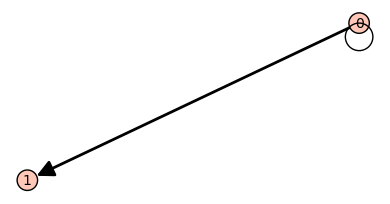

In [55]:
GPi.get_graph().show()

In [56]:
GPi.is_acyclic()

False

In [57]:
Pip = [({0,1,2},{}),({1,2,3},{}),({2,3},{4})]

In [58]:
GPip = Graph_Partition(5,Pip)

In [59]:
GPip.get_vertices()

[[0, 1, 2, 3], [4]]

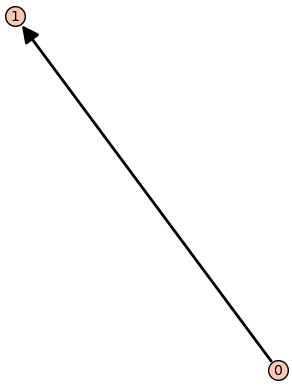

In [60]:
GPip.get_graph().show()

In [61]:
GPip.is_acyclic()

True

In [62]:
GPip.get_dim()

3

## Example
In the next example we recover the f-vector of $P_{2,3,1}=\Delta_{012}+\Delta_{123}$.

In [63]:
PP = get_face_partitions([[0,1,2],[1,2,3]])
dd = defaultdict(int)
for P in PP:
    G = Graph_Partition(4,P)
    if G.is_acyclic():
        dd[G.get_dim()] += 1
dd

defaultdict(<class 'int'>, {0: 7, 1: 11, 2: 6, 3: 1})

In the next example we recover the f-vector of $Q_2=\Delta_{0134}+\Delta_{1245}$.

In [64]:
PP = get_face_partitions([[0,1,3,4],[1,2,4,5]])
dd = defaultdict(int)
for P in PP:
    G = Graph_Partition(6,P)
    if G.is_acyclic():
        dd[G.get_dim()] += 1
dd        

defaultdict(<class 'int'>, {0: 14, 1: 37, 2: 43, 3: 26, 4: 8, 5: 1})

##  Section 4: one dimensional input layers

In [3]:
def Amatrix(k,s):
    def f(i,j):
        if i>= s and j<=k-s-1:
            if i-s == j:
                return 1
            else:
                return 0
        else:
            return 1
    return matrix(k,k, lambda i,j: f(i,j))

### Theorem 4.5:
Then, the generating function of the number $(b_n^{(k,s)})_{n\geq 1}$ of vertices of $P_{n,k,s}$ is given by
$$
\sum_{n\geq 0} b_{n+1}^{k,s}x^n = \frac{\sum_{i,j=1}^k (-1)^{i+j} Q_{i,j}(x)}{Q(x)},
$$
where $Q(x)=\det(I - x A_{k,s})$.


In [31]:
# generating function for the number of vertices of the polytopes P_{n,k,s} using the transfer-matrix theorem
def getGF(k,s):
    Q = (identity_matrix(k)-x*Amatrix(k,s))
    tot = 0
    for i in range(k):
        for j in range(k):
            R = list(range(k))
            C = list(range(k))
            R.remove(i)
            C.remove(j)
            tot += (-1)^(i+j)*Q.matrix_from_rows_and_columns(R,C).determinant()
    den = Q.determinant()
    return expand(tot)/expand(den)

For $k=3$ and $s=1$, the digraph $D_{3,1}$ is exactly the graph from Examples~\ref{ex: k=3 and s=1} and \ref{ex: asymptotics k=3 and s=1}. 
Thus the number $b_n^{(3,1)}$ of vertices of the polytope $P_{n,3,1}$ satisfies
$$
\sum_{n\geq 0} b_{n+1}^{(3,1)} x^n = \frac{3+x-x^2}{1-2x-x^2+x^3}.
$$

In [32]:
f = getGF(3,1)
f

-(x^2 - x - 3)/(x^3 - x^2 - 2*x + 1)

In [33]:
f.series(x,10)

3 + 7*x + 16*x^2 + 36*x^3 + 81*x^4 + 182*x^5 + 409*x^6 + 919*x^7 + 2065*x^8 + 4640*x^9 + Order(x^10)

### Theorem 4.2: (large strides $s\geq \lfloor k/2\rfloor$)
Fix positive integers $k$ and $s$ such that 
$s \in \{ \lceil k/2\rceil,\ldots,k-2 \}$. Then, the generating function of $(b_n^{(k,s)})_{n\geq 1}$ is given by
$$
1+\sum_{n\geq 1} b^{(k, s)}_{n} x^n
= \frac{1}{1-kx+(k-s)(k-s-1)x^2}. 
$$

In [13]:
# s>=floor(k/2)
def gfThm42(k,s):
    return 1/(1-k*x+(k-s)*(k-s-1)*x^2)

In [18]:
g = gfThm42(4,2)
g

1/(2*x^2 - 4*x + 1)

In [15]:
g.series(x,10)

1 + 4*x + 14*x^2 + 48*x^3 + 164*x^4 + 560*x^5 + 1912*x^6 + 6528*x^7 + 22288*x^8 + 76096*x^9 + Order(x^10)

### Theorem 4.3: (proportional strides $s\mid k$)
Fix positive integers $s$ and $r$ with $k=s(r+1)$. Then the generating function of $(b_n^{(k,s)})_{n\geq 1}$ is given by
$$
1+\sum_{n\geq 1} b_{n}^{(k,s)} x^n = 
\frac{
1+(rs-s-2)x-(rs-1)x^{2}+sx^{r+1}
}
{
1 - 2(s+1) x + (s +1)^2x^{2} + s x^{r + 1} - s^{2}(r + 1) x^{r + 2} + s(r s -1)x^{r + 3}
}.
$$

In [19]:
def gfThm43(r,s):
    num = 1+(r*s-s-2)*x-(r*s-1)*x^2+s*x^(r+1)
    den = 1-2*(s+1)*x+(s+1)^2*x^2+s*x^(r+1)-s^2*(r+1)*x^(r+2)+s*(r*s-1)*x^(r+3)
    return num/den


In [20]:
h = gfThm43(1,2)
h

(x^2 - 2*x + 1)/(2*x^4 - 8*x^3 + 11*x^2 - 6*x + 1)

In [21]:
h.series(x,10)

1 + 4*x + 14*x^2 + 48*x^3 + 164*x^4 + 560*x^5 + 1912*x^6 + 6528*x^7 + 22288*x^8 + 76096*x^9 + Order(x^10)

In [22]:
f = gfThm43(2,1)
f

(x^3 - x^2 - x + 1)/(x^5 - 3*x^4 + x^3 + 4*x^2 - 4*x + 1)

In [23]:
f.series(x,10)

1 + 3*x + 7*x^2 + 16*x^3 + 36*x^4 + 81*x^5 + 182*x^6 + 409*x^7 + 919*x^8 + 2065*x^9 + Order(x^10)

### Theorem 4.19
Let $s,k$ be such that $k>s+1$. The number of facets of $P_{n,k,s}$ is $(s+2)(n-1)+k$.
If $s,k$ are such that $ 1< k \leq  s+1$, then the number of facets is $kn$.

In [35]:
def numfacets(n,k,s):
    if k> s+1:
        return (s+2)*(n-1)+k
    elif 1<k and k<=s+1:
        return k*n

In [36]:
numfacets(2,3,1)

6

##  Section 5: two dimensional input layers

### Theorem 5.3:
The number of vertices $V_n$ of the polytope $Q_n$ 
is given by the generating function
$$
x + \sum_{n\geq 2} V_n x^n = \frac{x+x^2-x^3}{1-13x+31x^2-20x^3+4x^4} = x+ 14 x^2 + 150 x^3 + 1536 x^4 + 15594 x^5 + \cdots
$$

In [38]:
def gfThm53():
    return (x+x^2-x^3)/(1-13*x+31*x^2-20*x^3+4*x^4)

In [40]:
f = gfThm53()
f

-(x^3 - x^2 - x)/(4*x^4 - 20*x^3 + 31*x^2 - 13*x + 1)

In [41]:
f.series(x,10)

1*x + 14*x^2 + 150*x^3 + 1536*x^4 + 15594*x^5 + 158050*x^6 + 1601356*x^7 + 16223814*x^8 + 164366170*x^9 + Order(x^10)

## Section 6: Final Remarks

Table 2:  Initial terms for the number of edges of the polytopes $P_{n,k,1}$.

In [47]:
[len(PP(n,3,1).graph().edges()) for n in range(1,6)]

([{0, 1, 2}], [1])
([{0, 1, 2}, {1, 2, 3}], [1, 1])
([{0, 1, 2}, {1, 2, 3}, {2, 3, 4}], [1, 1, 1])
([{0, 1, 2}, {1, 2, 3}, {2, 3, 4}, {3, 4, 5}], [1, 1, 1, 1])
([{0, 1, 2}, {1, 2, 3}, {2, 3, 4}, {3, 4, 5}, {4, 5, 6}], [1, 1, 1, 1, 1])


[3, 11, 34, 96, 260]

Table 3: Initial terms for the total number of faces of the polytopes $P_{n,k,1}$.

In [49]:
[sum(PP(n,3,1).f_vector()) for n in range(1,6)]

([{0, 1, 2}], [1])
([{0, 1, 2}, {1, 2, 3}], [1, 1])
([{0, 1, 2}, {1, 2, 3}, {2, 3, 4}], [1, 1, 1])
([{0, 1, 2}, {1, 2, 3}, {2, 3, 4}, {3, 4, 5}], [1, 1, 1, 1])
([{0, 1, 2}, {1, 2, 3}, {2, 3, 4}, {3, 4, 5}, {4, 5, 6}], [1, 1, 1, 1, 1])


[8, 26, 88, 298, 1016]